In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

%ls /content/drive/MyDrive/MRP/dataset/HI-Small_Trans.csv
dataset_path="/content/drive/MyDrive/MRP/dataset/HI-Small_Trans.csv"

/content/drive/MyDrive/MRP/dataset/HI-Small_Trans.csv


In [ ]:
import pandas as pd
df=pd.read_csv(dataset_path)
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


In [ ]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['date'] = df['Timestamp'].dt.date
df['hour'] = df['Timestamp'].dt.hour
df['day'] = df['Timestamp'].dt.day
df['weekday'] = df['Timestamp'].dt.day_name()
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,date,hour,day,weekday
0,2022-09-01 00:20:00,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0,2022-09-01,0,1,Thursday
1,2022-09-01 00:20:00,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0,2022-09-01,0,1,Thursday
2,2022-09-01 00:00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0,2022-09-01,0,1,Thursday
3,2022-09-01 00:02:00,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0,2022-09-01,0,1,Thursday
4,2022-09-01 00:06:00,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0,2022-09-01,0,1,Thursday


In [ ]:
df = df.drop(columns=['Timestamp'])

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Label encode categorical columns
for col in ['Account', 'Account.1', 'Payment Format','Receiving Currency','Payment Currency','weekday','date']:
    df[col] = LabelEncoder().fit_transform(df[col])


In [ ]:
df.head()
df_sample=df.sample(n=10000, random_state=42)

In [ ]:
#Prepare features and labels
X = df.drop(columns=['Is Laundering'])
y = df['Is Laundering']
# Split Data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
# Create test and train dataset
train_df = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
test_df = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_test)], axis=1)

# Replace this with your desired folder path
folder_path = '/content/drive/MyDrive/MRP/dataset/'

# Save the files
train_df.to_csv(folder_path + 'train_set.csv', index=False)
test_df.to_csv(folder_path + 'test_set.csv', index=False)

# Random Forest

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from datetime import datetime

# SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train Random Forest
# rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model = RandomForestClassifier(
    n_estimators=25,
    max_depth=10,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)


t0 = datetime.now()
rf_model.fit(X_resampled, y_resampled)
running_secs = (datetime.now() - t0).seconds

print(f"Training time in seconds:{running_secs}")
# Predict and evaluate
y_rf_pred = rf_model.predict(X_test)
rf_report = classification_report(y_test, y_rf_pred, output_dict=True)
rf_report_df = pd.DataFrame(rf_report).transpose()



Training time in seconds:486


In [ ]:
rf_report_df

,precision,recall,f1-score,support
0,0.999789,0.935411,0.966529,1.521951e+06
1,0.012586,0.806825,0.024786,1.553000e+03
accuracy,0.935280,0.935280,0.935280,9.352801e-01
macro avg,0.506188,0.871118,0.495658,1.523504e+06
weighted avg,0.998783,0.935280,0.965569,1.523504e+06


In [ ]:
import pickle
import shutil
# Save model to file
model_filename = 'random_forest_clf_{0}.pkl'.format(1)
with open(model_filename, 'wb') as f:
    pickle.dump(rf_model, f)


with open(model_filename, 'wb') as f:
    pickle.dump(rf_model, f)

shutil.copy(model_filename, '/content/drive/MyDrive/MRP/model/{0}'.format(model_filename))

'/content/drive/MyDrive/MRP/model/random_forest_clf_1.pkl'

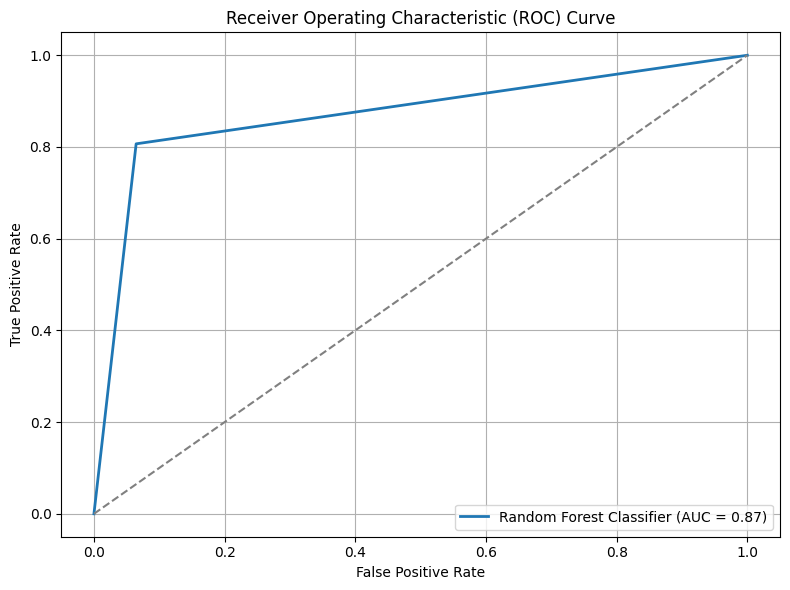

In [ ]:

# Compute ROC curve and AUC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)



fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest Classifier (AUC = {roc_auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

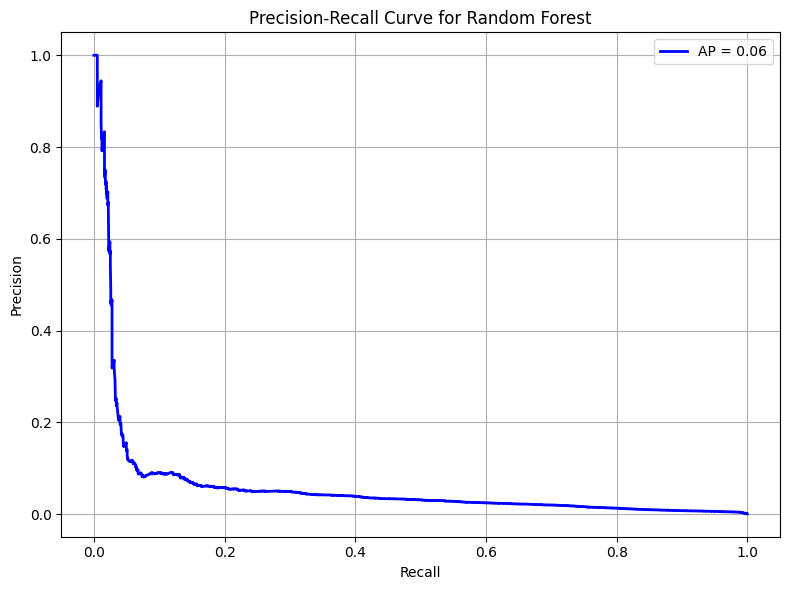

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Step 1: Predict probabilities for the positive class
y_scores = rf_model.predict_proba(X_test)[:, 1]  # Use your trained model

# Step 2: Compute precision-recall pairs
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Step 3: Compute average precision score
avg_precision = average_precision_score(y_test, y_scores)

# Step 4: Plot the PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AP = {avg_precision:.2f}', color='blue', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Random Forest')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Logistic Regression

In [ ]:
import pickle
from datetime import datetime
import shutil



# #Split Data into train and test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
# Train logistic regression
t0 = datetime.now()
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg.fit(X_train, y_train)
running_secs = (datetime.now() - t0).seconds

now = datetime.now()
dt_string = now.strftime("%d%m%Y%H%M%S")

# Evaluate
y_pred = logreg.predict(X_test)
# print(classification_report(y_test, y_pred))

# Save model to file
model_filename = 'logistic_regression_model_{0}.pkl'.format(1)
with open(model_filename, 'wb') as f:
    pickle.dump(logreg, f)


with open(model_filename, 'wb') as f:
    pickle.dump(logreg, f)

shutil.copy(model_filename, '/content/drive/MyDrive/MRP/model/{0}'.format(model_filename))

# Evaluation
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()



print(f"✅ Model saved to '{model_filename}'")
print(f"Training time in seconds:{running_secs}")
print("Classification Report:\n",classification_report(y_test, y_pred))




✅ Model saved to 'logistic_regression_model_1.pkl'
Training time in seconds:114
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.65      0.79   1521951
           1       0.00      0.59      0.00      1553

    accuracy                           0.65   1523504
   macro avg       0.50      0.62      0.39   1523504
weighted avg       1.00      0.65      0.78   1523504



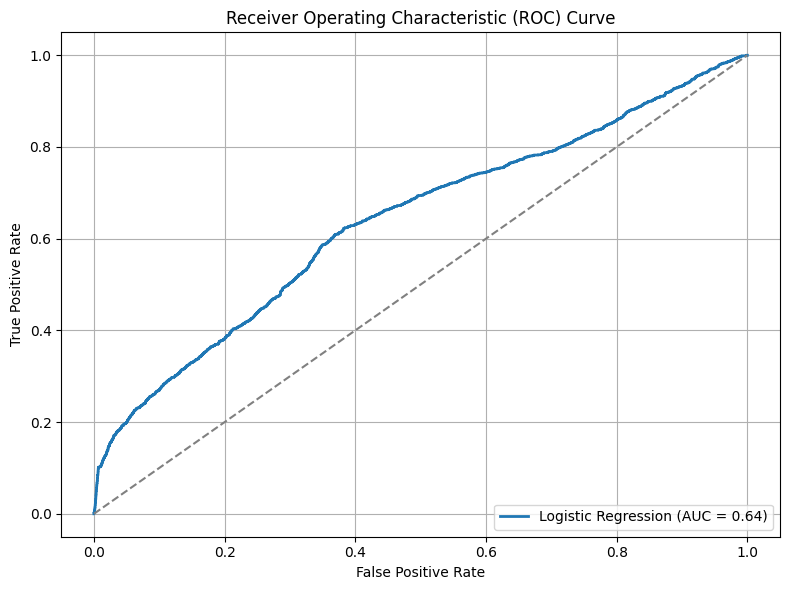

In [ ]:
# Compute ROC curve and AUC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities
y_prob = logreg.predict_proba(X_test)[:, 1]



fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
model_path = '/content/drive/MyDrive/MRP/model/logistic_regression_model_2.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(logreg, f)

# Step 4: Reload and run the model
with open(model_path, 'rb') as f:
    loaded_model = pickle.load(f)

y_loaded_pred = loaded_model.predict(X_test)
loaded_report = classification_report(y_test, y_loaded_pred, output_dict=True)
loaded_report_df = pd.DataFrame(loaded_report).transpose()
print("Classification Report:\n",classification_report(y_test, y_loaded_pred, output_dict=True))
loaded_report_df


Classification Report:
 {'0': {'precision': 0.9993505050330785, 'recall': 0.647025429859437, 'f1-score': 0.7854891175161487, 'support': 1521951.0}, '1': {'precision': 0.0016966381292009447, 'recall': 0.587894397939472, 'f1-score': 0.003383511588434542, 'support': 1553.0}, 'accuracy': 0.6469651540133797, 'macro avg': {'precision': 0.5005235715811397, 'recall': 0.6174599138994545, 'f1-score': 0.3944363145522916, 'support': 1523504.0}, 'weighted avg': {'precision': 0.9983335359569869, 'recall': 0.6469651540133797, 'f1-score': 0.7846918698515507, 'support': 1523504.0}}


,precision,recall,f1-score,support
0,0.999351,0.647025,0.785489,1.521951e+06
1,0.001697,0.587894,0.003384,1.553000e+03
accuracy,0.646965,0.646965,0.646965,6.469652e-01
macro avg,0.500524,0.617460,0.394436,1.523504e+06
weighted avg,0.998334,0.646965,0.784692,1.523504e+06


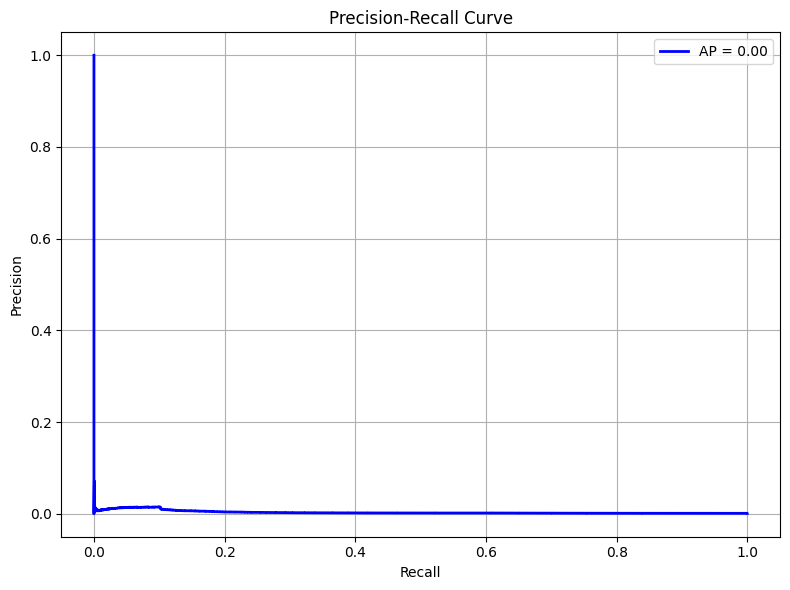

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Step 1: Predict probabilities for the positive class
y_scores = loaded_model.predict_proba(X_test)[:, 1]  # Use your trained model

# Step 2: Compute precision-recall pairs
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Step 3: Compute average precision score
avg_precision = average_precision_score(y_test, y_scores)

# Step 4: Plot the PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AP = {avg_precision:.2f}', color='blue', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# 1. Split the original dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 2. Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 3. Train logistic regression on resampled data
model = LogisticRegression(max_iter=1000)
model.fit(X_resampled, y_resampled)

# 4. Evaluate on original test set
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.65      0.79   1014634
           1       0.00      0.59      0.00      1035

    accuracy                           0.65   1015669
   macro avg       0.50      0.62      0.40   1015669
weighted avg       1.00      0.65      0.79   1015669

